In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

## Two-dimensional models

Next we'll look at a common model of *two* populations.
First, here's some code that will come in handy,
for running simulations (`run_sim_2d( )`, much as before.

In [3]:
def run_sim_2d(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        N[t, :], M[t, :] = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
    return N, M


## Species interactions



Let's generalize logistic-type population dynamics to more types. When there are $N$ individuals of type 0 and $M$ of type 1, then:

1. Each time step, each type-0 individual has probability $p_0$ of dying,
   and producing a Poisson number of offspring.
2. The mean number of offspring depends on the current amount of resources:
   it is equal to $\lambda_0 \exp(- (N + a_0 M)/K_0)$.
3. Same, vice-versa.

*Note:* here death and reproduction are coupled, like for an annual plant.

How do we expect this to behave?
Let's write down the *expected* dynamics:
$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = N, M_t = M]
      &= F(N, M) \\
      &= N (1 - p_0) + p_0 N \lambda_0 \exp(- (N + a_0 M)/K_0) \\
  \mathbb{E}[M_{t+1} | N_t = N, M_t = M]
      &= G(N, M) \\
      &= M (1 - p_1) + p_1 N \lambda_1 \exp(- (M + a_1 N)/K_1) .
\end{aligned}$$


### Aside: the Lotka-Volterra equations

The differential equations we'd get here are:
$$\begin{aligned}
  \frac{dN}{dt}
      &= r_0 N_t \exp\left( - \frac{N_t + a_0 M_t}{K_0} \right) \\
  \frac{dM}{dt}
      &= r_1 M_t \exp\left( - \frac{M_t + a_1 N_t}{K_1} \right) 
\end{aligned}$$
This is a multivariate version of the Ricker model;
the more famous Lotka-Volterra equations are the "logistic" analogue,
with $(1-N/K)$ instead of $\exp(-N/K)$.

### Simulation

First, let's look at the time series of the two population sizes,
both from a stochastic simulation
and iteration of the deterministic equations.
(If they don't look similar, we probably made a mistake.)

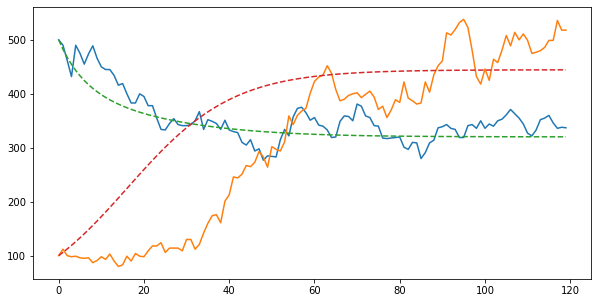

In [4]:
def lv_eqn(N, M, lam, p, K, a):
    # this is F and G
    next_N = N + p[0] * N * (lam[0] * np.exp(-(N + a[0] * M)/K[0]) - 1)
    next_M = M + p[1] * M * (lam[1] * np.exp(-(M + a[1] * N)/K[1]) - 1)
    return next_N, next_M

def lv_gen(N, M, lam, p, K, a):
    # this is simulating as described above
    assert(len(M) == len(N))
    N_dies = np.random.binomial(N, p[0])
    M_dies = np.random.binomial(M, p[1])
    N_repro = np.random.poisson(N_dies * lam[0] * np.exp(-((N + a[0]*M)/K[0])))
    M_repro = np.random.poisson(M_dies * lam[1] * np.exp(-((M + a[1]*N)/K[1])))
    next_N = N - N_dies + N_repro
    next_M = M - M_dies + M_repro
    return next_N, next_M

# we'll use **kwargs to avoid re-typing these over and over
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # survival prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }

# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)
# deterministic
tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                    **lv_args)

fig, ax = plt.subplots()
ax.plot(np.column_stack([N, M]))
ax.plot(np.column_stack([tN, tM]), linestyle="--");

### Equilibrium

Note that $\mathbb{E}[N_{t+1}] = N$ only if 
$\lambda_0 \exp(- (N + a_0 M)/K_0) = 1$,
and this happens only if
$(N + a_0 M)/K_0 = \log \lambda_0$.

Writing out the equations for both species,
equilibrium occurs when
$$\begin{aligned}
  N + a_0 M &= K_0 \log(\lambda_0) \\
  a_1 N + M &= K_1 \log(\lambda_1)  
\end{aligned}$$
which is solved by
$$\begin{aligned}
  N &= \frac{K_0 \log(\lambda_0) - a_0 K_1 \log(\lambda_1)}{1 - a_0 a_1} \\
  M &= \frac{K_1 \log(\lambda_1) - a_1 K_0 \log(\lambda_0)}{1 - a_0 a_1} .
\end{aligned}$$

In [5]:
def lv_equil(lam, p, K, a):
    return np.array([K[0] * np.log(lam[0]) - a[0] * K[1] * np.log(lam[1]),
                     K[1] * np.log(lam[1]) - a[1] * K[0] * np.log(lam[0])]) / (1 - a[0] * a[1])


equil = lv_equil(**lv_args)
print("equilibrium:", equil)

equilibrium: [320.18992291 444.53190673]


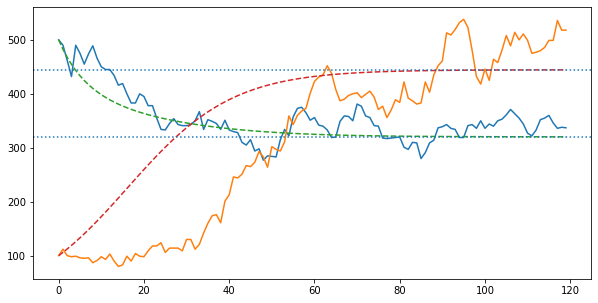

In [6]:
for a in equil:
    ax.axhline(a, linestyle=":");
fig

### Phase plots

We really want to think of the basic equations
as telling us which way the system is "pushed".
A nice way to view this is as a *vector field* of arrows
in *phase space*.
Here is code to make these plots.
(But, you should probably look at the result, first!)

In [7]:
def phase_plot(genfn, xlim, ylim, nx, ny, **kwargs):
    xstep = int((xlim[1] - xlim[0]) / nx)
    ystep = int((ylim[1] - ylim[0]) / ny)
    X, Y = np.meshgrid(range(xlim[0], xlim[1], xstep), range(ylim[0], ylim[1], ystep))
    X.shape = Y.shape = (np.prod(X.shape),)
    U, V = genfn(X, Y, **kwargs)
    fig, ax = plt.subplots()
    ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=1)
    ax.axis('equal')
    return fig, ax

Here is a phase plot for this system,
along with the deterministic trajectory starting from a single point,
and converging to the equilibrium.

In [8]:
def do_plot(lv_args):  
    equil = lv_equil(**lv_args)

    tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                        **lv_args)

    plt.rcParams['figure.figsize'] = [10, 10]
    fig, ax = phase_plot(lv_eqn, xlim=[0, 600], ylim=[0, 600], nx=20, ny=20,
                         **lv_args)
    ax.plot(tN, tM)
    ax.scatter(tN, tM)
    ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
    plt.xlabel("N")
    plt.ylabel("M")
    return fig, ax

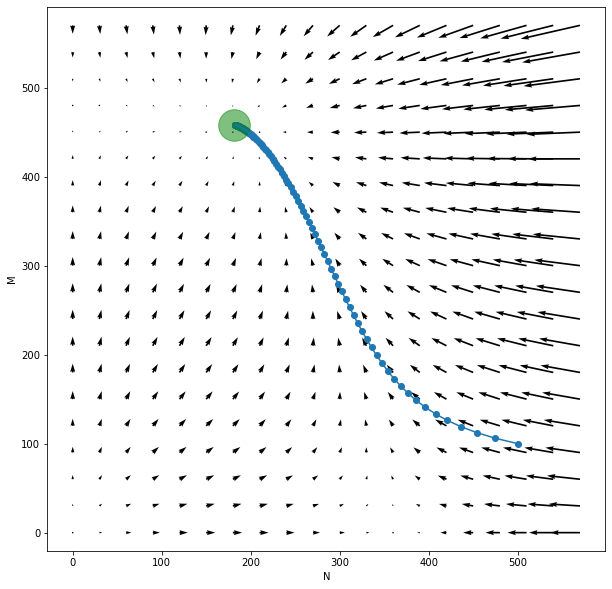

In [36]:
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.6, 0.9],      # death prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.4, 0.1]  # encounter rate
    }
fig, ax = do_plot(lv_args)

And, here is a stochastic simulation trajectory.
(Run again to add more.)

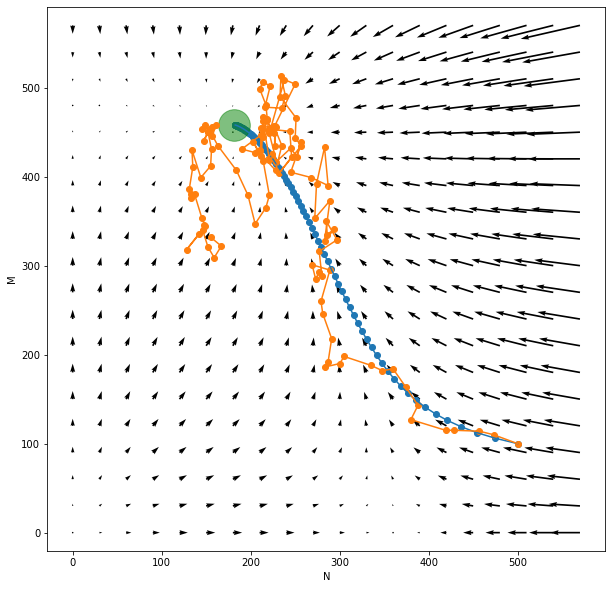

In [37]:
# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)
ax.plot(N, M)
ax.scatter(N, M)
fig

### Exercise

If $K_0 \log(\lambda_0) < a_0 K_1 \log(\lambda_1)$
and/or $K_1 \log(\lambda_1) < a_1 K_0 \log(\lambda_0)$
then there is no stable equilibrium with both species coexisting.
Investigate with simulations to verify this,
and explain intuitively why coexistence fails.

### Homework

We can get very different behavior of this system
for different values of $a_0$ and $a_1$.
Here is a taxonomy:


|  a_0  |  a_1  | interaction |
|-------|-------|-------------|
|   -   |   -   | mutualism   |
|   -   |   0   | commensal   |
|   +   |   -   | parasitic   |
|   +   |   +   | competition |


Plot simulation results in phase space
of example parameters for each of the four interactions,
both (a) with stable coexistence,
and (b) without (where one goes extinct).
Do you have any observations about where the transition occurs?

## Isoclines

A nice way to look at phase plots
is to draw on them the *isoclines*,
i.e., the lines along which each variable does not change.
We saw above that $N$ does not change if
$$\begin{aligned}
  N + a_0 M &= K_0 \log(\lambda_0),
\end{aligned}$$
and $M$ does not change if
$$\begin{aligned}
  a_1 N + M &= K_1 \log(\lambda_1) . 
\end{aligned}$$
In this example these turn out to be *straight lines* in phase space.

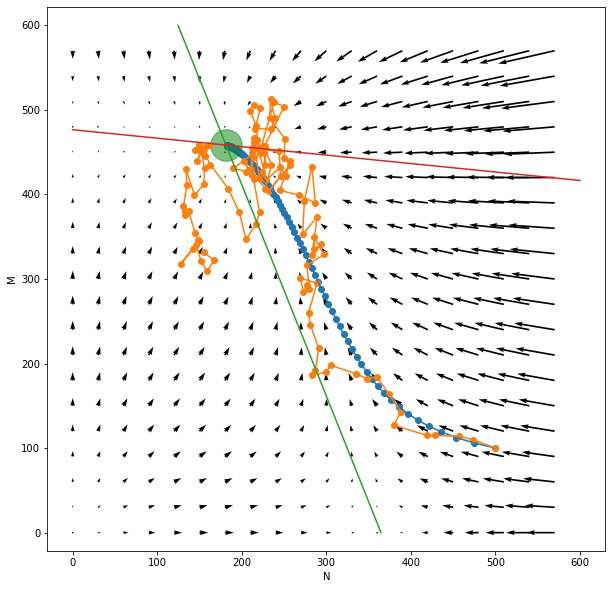

In [38]:
xx = np.array([0.0, 600])
ax.plot(lv_args['K'][0] * np.log(lv_args['lam'][0]) - xx * lv_args['a'][0], xx)
ax.plot(xx, lv_args['K'][1] * np.log(lv_args['lam'][1]) - xx * lv_args['a'][1])
fig

### Another set of parameters 

Here's fun set of parameters.

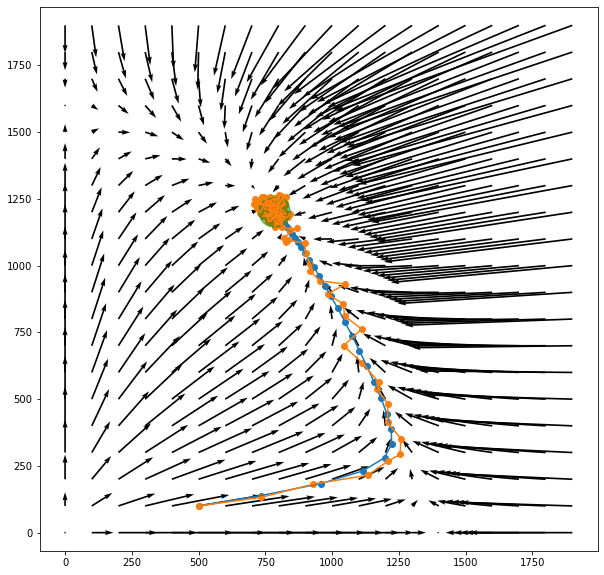

In [41]:
lv_args = {
        'lam' : [2.0, 2.9],    # fecundity
        'p' : [0.9, 0.3],      # survival prob
        'K' : [2000, 1500],    # carrying capacity
        'a' : [0.5, 0.5]       # encounter rate
    }

# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)

# deterministic
tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                    **lv_args)
equil = np.fmin(2000, np.fmax(0.0, lv_equil(**lv_args)))

fig, ax = phase_plot(lv_eqn, xlim=[0, 2000], ylim=[0, 2000], nx=20, ny=20,
                     **lv_args)
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.plot(N, M)
ax.scatter(N, M)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5);

# Susceptible-Infected

The parameters are:

- $\lambda$ : birth rate of new individuals (`lambda`)
- $c$ : per capita encounter rate
- $a$ : transmission rate per encounter
- $\rho$ : recovery rate (`rho`)
- $\mu$ : death rate of susceptible individuals (`mu`)
- $\delta$ : death rate of infected individuals (`delta`)

The equations for the number of susceptible ($S$) 
and the number of infected ($I$) individuals are:
$$\begin{aligned}
  \frac{dS}{dt} &= \lambda - \mu S - a c S I + \rho I \\
  \frac{dI}{dt} &= a  c S I - \delta I - \rho I  
\end{aligned}$$


Text(0, 0.5, 'I')

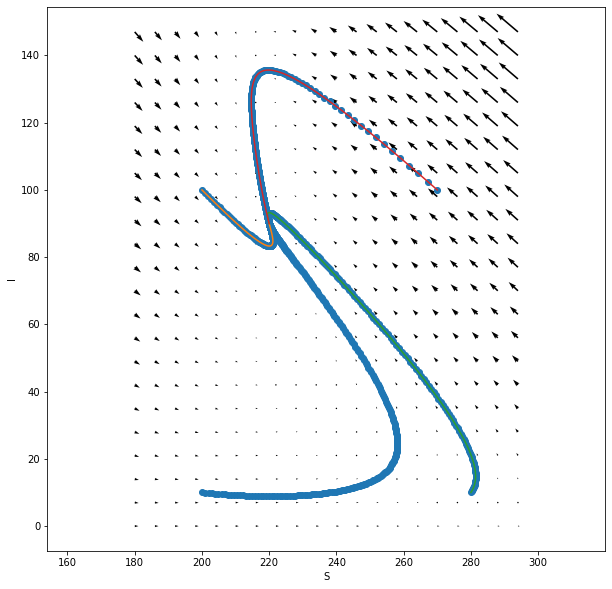

In [46]:
def SI_eqn(N, M, dt, lam, c, a, rho, mu, delta):
    next_N = N +  dt * (lam - mu * N - a * c * N * M + rho * M)
    next_M = M + dt * (a * c * N * M - delta * M - rho * M)
    return next_N, next_M

SI_args = {'dt' : 0.5, 'lam' : 4, 'c' : 0.01, 'a' : 0.1, 'rho' : 0.2, 'mu' : 0.01, 'delta' : 0.02}

tN, tM = run_sim_2d([200, 200, 280, 270], [10, 100, 10, 100], SI_eqn, 1000, dtype='float',
               **SI_args)

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = phase_plot(SI_eqn, xlim=[180, 300], ylim=[0, 150], nx=20, ny=20,
                 **SI_args)
ax.plot(tN, tM)
ax.scatter(tN, tM)
plt.xlabel("S")
plt.ylabel("I")

## Alternative homework: Make a model

Design a stochastic version of this
and simulate from it.